# Chapter 15 - Natural Language Processing: Pretraining

## 15.1. Word Embedding (word2vec)

In natural language processing, words are the basic unit of the meaning. The *word vectors* are vectors used to represent words, and can also be considered as feature vectors or representations of words.

The technique of mapping words to real vectors is called *word embedding*. 

### 15.1.1. One-Hot Vectors Are a Bad Choice

Suppose that the number of different words in the dictionary (the dictionary size) is $N$, and each word corresponds to a different integer (index) from 0 to $N-1$. To obtain the one-hot vector representation for any word with index $i$, we create a length-$N$ vector with all 0s and set the element at position $i$ to 1.

However, one-hot word vectors cannot accurately express the similarity between different words, such as the *cosine similarity*. For vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their cosine similarity is the cosine of the angle between them:
\begin{split}
\frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1].
\end{split}
Since the cosine similarity between one-hot vectors of any two different words is 0, one-hot vectors cannot encode similarities among words.

### 15.1.2. Self-Supervised word2vec

The word2vec algorithm maps each word to a fixed-length vector, and thes vectors can better express the similarity and analogy relationships among different words.

The word2vec algorithm contains two models:
* *skip-gram*, and
* *continuous bag of words (CBOW)*.

Since supervision comes from the data without labels, both skip-gram and continuous bag of words are self-supervised learning models.

### 15.1.3. The Skip-Gram Model

The *skip-gram* model assumes that *a word can be used to generate its surrounding words in a text squence*.

For example, suppose a text squence, "the", "man", "loves", "his", "son". If "loves" is chosen as the *center word* and we set the context window size to 2. As shown in the figure below, given the center word "loves", the skip-gram model considers the conditional probability for generating the *context words*: "the", "man", "his", "son", which are no more than 2 words away from the center word:
\begin{split}
P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).
\end{split}

![](../imgs/ch15/skip-gram.svg)

Assume that the context words are independently generated given the center words (i.e., conditional independence). Then, the above conditional probability can be rewritten as
\begin{split}
P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}) = P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).
\end{split}

Each word in this model has two $d$-dimensional vector representations to calculate conditional probabilities.

For any word with index $i$ in the dictionary, denote by $\mathbf{v}_i \in \mathbb{R}^d$ and $\mathbf{u}_i \in \mathbb{R}^d$ its two vectors when used as a *center word* and a *context word*, respectively. The conditional probability of generating any context word $w_o$ (with index $o$ in the dictionary) given the center word $w_c$ (with index $c$ in the dictionary) can be modeled by a softmax operation on vector dot products:
\begin{split}
P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)},
\end{split}
where the vocabulary index set is $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$.

Given a text sequence of length $T$, where the word at time step $t$ is denoted by $w^{(t)}$. Assume that context words are independently generated given any center word. For context window size $m$, the likelihood function of the skip-gram model is the probability of generating all context words given any center word:
\begin{split}
\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),
\end{split}
where any time step that is less than 1 or greater than $T$ can be ignored.

#### 15.1.3.1. Training

The model parameters in the skip-gram model are the center word vectors and the context word vectors for each word in the vocabulary.

During training, we learn the model parameters by maximizing the likelihood function (i.e., maximum likelihood estimation), which is equivalent to minimizing the following loss function:
\begin{split}
- \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \textrm{log}\, P(w^{(t+j)} \mid w^{(t)}).
\end{split}

Using SGD to minimize this loss function, in each iteration, we can randomly sample a shorter subsequence to calculate the (stochastic) gradient for this subsequence to update the model parameters.

The (stochastic) gradients are the gradients of the log conditional probability with respect to the center word vector and the context word vector. Recall in the previous section that the log conditional probability involving any pair of the center word $w_c$ and the context word $w_o$ is
\begin{split}
\log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)\right).
\end{split}

Its gradient with respect to the center word vector $\mathbf{v}_c$ is
\begin{split}
\begin{aligned}
\frac{\partial \textrm{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.
\end{aligned}
\end{split}
which requries the conditional probabilities of all words in the dictionary with $w_c$ as the center word.

After training, for any word with index $i$ in the dictionary, we obtain both word vectors $\mathbf{v}_i$ (as the center word) and $\mathbf{u}_i$ (as the context word).

In NLP, the center word vectors of the skip-gram model are typically used as the word representations.

### 15.1.4. The Continuous Bag of Words (CBOW) Model

The *continuous bag of words (CBOW)* model is similar to the skip-gram model. The main difference is that the CBOW model assumes that *a center word is generated based on its surrounding context words in the text sequence*.

Using the same text sequence, "the", "man", "loves", "his", "son", with "loves" as the center word and the context window size being 2, the continuous bag of words model consideres the conditional probability of generating the center word "loves" based on the context words "the", "man", "his", "son":
\begin{split}
P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).
\end{split}
as shown in the figure below.

![](../imgs/ch15/cbow.svg)

Since there are multiple context words in the CBOW model, these context word vectors are averaged in the calculation of the conditional probability.

For any word with index $i$ in the dictionary, denote by $\mathbf{v}_i \in \mathbb{R}^d$ and $\mathbf{u}_i \in \mathbb{R}^d$ its two vectors when used as a *context word* and a *center word*, respectively, (the reverse of the skip-gram model). The conditional probability of generating any center word $w_c$ (with index $c$ in the dictionary) given the context words $w_{o_1}, \ldots, w_{o_{2m}}$ (with indices $o_1, \ldots, o_{2m}$ in the dictionary) can be modeled by
\begin{split}
P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\exp\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \exp\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}.
\end{split}

For brevity, let $\mathcal{W}_o = \{w_{o_1}, \ldots, w_{o_{2m}}\}$ denote the set of context words and $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}\right)/(2m)$ denote their average. Then, the above conditional probability can be rewritten as
\begin{split}
P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.
\end{split}

Given a text sequence of length $T$, where the word at time step $t$ is denoted by $w^{(t)}$. For context window size $m$, the likelihood function of the CBOW model is the probability of generating all center words given any context words:
\begin{split}
\prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).
\end{split}

#### 15.1.4.1. Training

Training the CBOW model is similar to training the skip-gram model.

The maximum likelihood estimation of the CBOW model is equivalent to minimizing the following loss function:
\begin{split}
-\sum_{t=1}^T  \textrm{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).
\end{split}

Note that
\begin{split}
\log\,P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log\,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).
\end{split}

Hence, its gradient with respect to the context word vector $\mathbf{v}_{o_i}$ ($i = 1, \ldots, 2m$) is
\begin{aligned}
\frac{\partial \log\, P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} &= \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) \\
&= \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).
\end{aligned}

Unlike the skip-gram model, the continuous bag of words model typically uses context word vectors as the word representations.

## 15.2. Approximate Training

The gradient calculation of the skip-gram and CBOW models involves the sum of all conditional probabilities of words in the dictionary. When the dictionary is large, the sum of all conditional probabilities is computationally expensive.

To reduce the aforementioned computational cost, we can use *negative sampling* and *hierarchical softmax* to approximate the maximum likelihood estimation of the skip-gram and CBOW models.

### 15.2.1. Negative Sampling

*Negative sampling* modifies the original objective function.

Given the context window of a center word $w_c$, the fact that any (context) word $w_o$ comes from this context window is considered as an event with the probability modeled by
\begin{split}
P(D=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c),
\end{split}
where $\sigma$ is the sigmoid function:
\begin{split}
\sigma(x) = \frac{1}{1+\exp(-x)}.
\end{split}

Given a text sequence of lenght $T$, denote by $w^{(t)}$ the word at time step $t$ and let the context window size be $m$, the joint probability of generating all context words in the text sequence is
\begin{split}
\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}).
\end{split}

This joint probability is maximized to 1 only if all the word vectors are equal to infinity. To make the objective function more meaningful, *negative sampling* adds negative examples sampled from a predefined distribution.

Denote by $S$ the event that a context word $w_o$ comes from the context window of a center word $w_c$. 

For this event involving $w_o$, from a predefined distribution $P(w)$, we can sample $K$ *noise words* that are not from this context window. Denote by $N_k$ the event that a noise word $w_k$ ($k = 1, \ldots, K$) does not come from the context window of $w_c$.

Assume that these events involving both the positive example $S$ and the negative examples $N_1, \ldots, N_K$ are mutually independent. Then, the negative sampling rewrites the joint probability (involving only positive examples $S$) as
\begin{split}
\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}) = \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),
\end{split}
where the conditional probability is approximated through events $S, N_1, \ldots, N_K$:
\begin{split}
P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).
\end{split}

Denote by $i_t$ and $h_k$ the indices of a word $w^{(t)}$ at time step $t$ of a text sequence and a noise word $w_k$, respectively. The logarithmic loss with respect to the conditional probabilities of the positive example and the negative examples is
\begin{split}\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\ w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}\end{split}

The computational cost for gradients at each training step does not depend on the dictionary size, but linearly depends on $K$. When setting the hyperparameter $K$ to a smaller value, the computational cost for gradients at each training with negative sampling is smaller.

### 15.2.2. Hierarchical Softmax

The *hierarchical softmax* uses a binary where each leaf node of the tree represents a word in the dictionary $\mathcal{V}$, as shown in the figure below.

![](../imgs/ch15/hi-softmax.svg)

Denote by $L(w)$ the number of nodes (including both ends) on the path from the root node to the leaf node representing word $w$ in the binary tree.

Let $n(w,j)$ be the $j$-th node on this path, with its context word vector being $\mathbf{u}_{n(w,j)}$. For instance, in the figure above, $L(w_3) = 4$ since the path from the root node to the leaf node representing $w_3$ is $n(w_3, 1)$, $n(w_3, 2)$, $n(w_3, 3)$ and $w_3$.

The *hierarchical softmax* approximates the conditional probability 
\begin{split}
P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)},
\end{split}
as
\begin{split}
P(w_o \mid w_c) = \prod_{j=1}^{L(w_o)-1} \sigma\left( [\![  n(w_o, j+1) = \textrm{leftChild}(n(w_o, j)) ]\!] \cdot \mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_c\right),
\end{split}
where $\sigma$ is the sigmoid function and $\textrm{leftChild}(n)$ is the left child node of $n$: if $x$ is true, then $[\![x]\!] = 1$; otherwise, $[\![x]\!] = -1$.

In the figure above, if we want to calculate the conditional probaility of generating word $w_3$ given word $w_c$, we need to calculate the dot products between the word vector $\mathbf{v}_c$ of $w_c$ and non-leaf node vectors on the path (the bold line segments in the figure above) from the root to $w_3$, which is traversed left, right, and then left:
\begin{split}
P(w_3 \mid w_c) = \sigma(\mathbf{u}_{n(w_3, 1)}^\top \mathbf{v}_c) \cdot \sigma(-\mathbf{u}_{n(w_3, 2)}^\top \mathbf{v}_c) \cdot \sigma(\mathbf{u}_{n(w_3, 3)}^\top \mathbf{v}_c).
\end{split}

Since $\sigma(x) + \sigma(-x) = 1$, it holds that the conditional probabilities of generating all the words in dictionary $\mathcal{V}$ based on any word $w_c$ sum up to one:
\begin{split}
\sum_{w \in \mathcal{V}} P(w \mid w_c) = 1.
\end{split}

Since $L(w_o) - 1$ is the order of $\mathcal{O}(\log_2 |\mathcal{V}|)$ due to the binary tree structure, when the dictionary size $|\mathcal{V}|$ is large, the computational cost for each training step of the hierarchical softmax is significantly reduced compared with that without approximate training.

## 15.3. The Dataset for Pretraining Word Embeddings

In [4]:
import collections
import os
import math
import random
import torch

from d2l import torch as d2l

### 15.3.1. Reading the Dataset

The Penn Tree Bank (PTB) is a widely used dataset for language modeling. This corpus is sampled from Wall Street Journal articles. In the original format, each line of the text file represents a sentence of words that are separated by spaces. We will treat each word as a token.

In [5]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

In [6]:
def read_ptb():
    '''Load the PTB dataset into a list of text lines'''
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()

    return [line.split() for line in raw_text.split('\n')]

In [7]:
sentences = read_ptb()
print(f'# sentences: {len(sentences)}')

# sentences: 42069


We need to build a vocabulary for the corpus after reading the dataset. Any word that appears less than 10 times is replaced by the `<unk>` token.

In [8]:
vocab = d2l.Vocab(sentences, min_freq=10)
print(f'vocabulary size: {len(vocab)}')

vocabulary size: 6719


### 15.3.2. Subsampling

Text data typically have high-frequency words such as “the”, “a”, and “in”: they may even occur billions of times in very large corpora. However, these words often co-occur with many different words in context windows, providing little useful signals.

When training word embedding models, high-frequency words can be *subsampled*. Each indexed word $w_i$ in the dataset will be discarded with probability
\begin{split}
P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),
\end{split}
where $f(w_i)$ is the ratio of the number of words $w_i$ to the total number of words in the dataset, and the constant $t$ is a hyperparameter.

When the relative frequency $f(w_i)>t$, the word $w_i$ can be discarded. The higher the relative frequency of the word, the greater the probability of being discarded.

In [9]:
def subsample(sentences, vocab):
    '''Subsample high-frequency words'''
    # exclude unkown tokens '<unk>'
    sentences = [
        [token for token in line if vocab[token] != vocab.unk]
        for line in sentences
    ]
    counter = collections.Counter(
        [token for line in sentences for token in line]
    )

    num_tokens = sum(counter.values())

    # return True if `token` is kept during subsampling
    def keep(token):
        t = 1e-4 # threshold for subsampling
        f_w = counter[token] / num_tokens
        prob = math.sqrt(t / f_w)
        return random.uniform(0, 1) < prob
    
    return (
        [[token for token in line if keep(token)] for line in sentences],
        counter
    )

In [10]:
subsampled, counter = subsample(sentences, vocab)

We can plot the histogram of the number of tokens per sentence before and after subsampling.

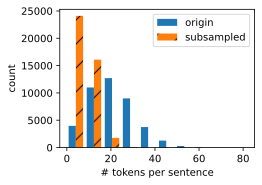

In [11]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'],
    '# tokens per sentence',
    'count',
    sentences,
    subsampled
);

In [12]:
def compare_counts(token):
    return (
        f'# of "{token}": '
        f'before={sum([l.count(token) for l in sentences])}, '
        f'after={sum([l.count(token) for l in subsampled])}'
    )

In [13]:
compare_counts('the')

'# of "the": before=50770, after=1971'

For individual tokens, the sampling rate of the high-frequency words "the" is less than 1/20.

On the other hand, low-frequency words "join" are the same.

In [14]:
compare_counts('join')

'# of "join": before=45, after=45'

After subsampling, we map tokens to their indices for the corpus:

In [15]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[], [6697, 3228, 710, 1773], [3922, 1922, 4743]]

These indices correspond to

In [16]:
subsampled[0:3]

[[], ['years', 'join', 'board', 'director'], ['n.v.', 'dutch', 'publishing']]

### 15.3.3. Extracting Center Words and Context Words

The `get_centers_and_contexts` function extracts all the center words and their context words from `corpus`. It uniformly samples an integer between 1 and `max_window_size` at random as the context window size.

In [17]:
def get_centers_and_contexts(corpus, max_window_size):
    '''Return center words and context words in skip-gram'''
    centers = []
    contexts = []

    for line in corpus:
        # To form a "center word--context word" pair,
        # each sentence needs to have at least 2 words
        if len(line) < 2:
            continue

        # add line to centers
        centers += line
        for i in range(len(line)): # context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(
                max(0, i - window_size), # left limit
                min(len(line), i + 1 + window_size), # right limit
            ))
            # exclude the center word from the context words
            indices.remove(i)
            # add remaining words to contexts
            contexts.append([line[idx] for idx in indices])

    return centers, contexts

Now we can create an artificial dataset containing two sentences of 7 and 3 words, respectively. Let the maximum context window size be 2 nad print out all the center words and their context words.

In [17]:
tiny_dataset = [
    list(range(7)), # a sentence with 7 tokens
    list(range(7, 10)) # another sentence with 3 tokens
]
max_window_size = 2

print('dataset: ', tiny_dataset)
centers, contexts = get_centers_and_contexts(tiny_dataset, max_window_size)
for center, context in zip(centers, contexts):
    print('center', center, 'has contexts', context)

dataset:  [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [8]


There is randomness in the sampling of context windows. Hence, the output of the following code may vary.

When training on the PTB dataset, we set the maximum context window size to 5.

In [19]:
max_window_size = 5
all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
print(f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}')

# center-context pairs: 1500707


### 15.3.4. Negative Sampling

We will use negative sampling for approximate training.

To sample noise words according to a predefined distribution, we define the `RandomGenerator` class, where the (possibly unnormalized) sampling distribution is passed via the argument `sampling_weights`.

In [18]:
class RandomGenerator:
    '''Randomly draw among {1,..., n} according to n sampling weights'''
    def __init__(self, sampling_weights):
        # exclude 0 for convenience
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # cache `k` random sampling results
            self.candidates = random.choices(
                self.population,
                self.sampling_weights,
                k=10000
            )
            self.i = 0
        
        self.i += 1
        return self.candidates[self.i - 1]

We can draw 10 random variables $X$ among indices 1, 2, and 3 with sampling probability
\begin{split}
P(X=1)=2/9, P(X=2)=3/9, \textrm{and } P(X=3)=4/9.
\end{split}

In [21]:
sampling_weights = [2, 3, 4] # 3 tokens with weights 2, 3 and 4
generator = RandomGenerator(sampling_weights)
[generator.draw() for _ in range(10)]

[2, 1, 3, 3, 2, 3, 3, 2, 3, 1]

For a pair of center word and context word, we randomly sample `K` (5 in the experiment) noise words. In the word2vec paper, the sampling probability $P(w)$ of a noise word $w$ is set to its relatie frequency in the dictionary raised to the power of 0.75.

In [19]:
def get_negatives(all_contexts, vocab, counter, K):
    '''Return noise words in negative sampling'''
    # Sampling weights for words with indices 1, 2, ...
    # (index 0 is the excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]

    all_negatives = []
    generator = RandomGenerator(sampling_weights)

    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)

        all_negatives.append(negatives)

    return all_negatives

In [23]:
all_negatives = get_negatives(all_contexts, vocab, counter, 5)

### 15.3.5. Loading Training Examples in Minibatches

After all the center words together with their context words and sampled noise words are extracted, they will be transformed into minibatches of examples that can be iteratively loaded during training.

In a minibatch, the $i$-th example includes a center word and its $n_i$ context words and $m_i$ noise words. Due to varying context window sizes, $n_i + m_i$ varies for different $i$. Thus, for each example in a minibatch, we concatenate its context words and noise words in the `contexts_negatives` variable, and padd zeros until the concatenation length reaches the maximum context window size $\max_i n_i + m_i$ (`max_len`) in the minibatch.

To exclude paddings in the calculation of the loss, we define a mask variable `masks`. There is a one-to-one correspondence between elements in `masks` and elements in `contexts_negatives`, where zeros (otherwise ones) in `masks` correspond to paddings (otherwise non-paddings) in `contexts_negatives`.

To distinguish between positive and negative examples in `contexts_negatives`, we separte context words from noise words via a `labels` variable. Similar to `masks`, there is also a one-to-one correspondence between elements in `labels` and elements in `contexts_negatives`, where ones (otherwise zeros) in `labels` correspond to context words (positive examples) in `contexts_negatives`.

In the `batchify` function below, its input `data` is a list with length equal to the batch size, where each element is an example consisting of the center word `center`, its context words `context`, and its noise words `negatives`. This function returns a minibatch that can be loaded for calcualtions during training.

In [20]:
def batchify(data):
    '''Return a minibatch of examples for skip-gram with negative sampling'''
    # data: (batch size, centers, contexts, negatives)
    max_len = max(len(c) + len(n) for _, c, n in data)
    # minibatch of center words
    centers = []
    # minibatch of context words and noise words associated with the center word
    contexts_negatives = []
    # mask for non-padding entries
    masks = []
    # mask for context words and noise words
    labels = []

    for center, context, negative in data:
        # take one example
        cur_len = len(context) + len(negative)
        # add center word
        centers += [center]
        # add context words, noise words, and padding associated with the center word
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        # add mask for padding
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        # add mask for context words
        labels += [[1] * len(context) + [0] * (max_len - len(context))]

    return (
        torch.tensor(centers).reshape((-1, 1)), # (batch size, 1) for center words
        torch.tensor(contexts_negatives), # (batch size, max_len) for context words and noise words
        torch.tensor(masks), # (batch size, max_len) for mask
        torch.tensor(labels) # (batch size, max_len) for mask
    )

In [26]:
# test a minibatch of three examples
X1 = (1, # center word
      [2, 2], # context words
      [3, 3, 3, 3]) # noise words
X2 = (4, # center word
      [2, 2, 2], # context words
      [3, 3]) # noise words
X3 = (1, # center word
      [3, 3, 3, 1], # context words
      [4, 4, 2, 2]) # noise words

examples = [X1, X2, X3]
batch = batchify(examples)

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [4],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3, 0, 0],
        [2, 2, 2, 3, 3, 0, 0, 0],
        [3, 3, 3, 1, 4, 4, 2, 2]])
masks = tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])
labels = tensor([[1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0]])


### 15.3.6. Putting It All Together

In [22]:
# create a dataset class
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        # centers, contexts, and negatives are of equal length
        assert len(centers) == len(contexts) == len(negatives)

        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (
            self.centers[index], # center word
            self.contexts[index], # positive context words
            self.negatives[index], # negative noise words
        )
    
    def __len__(self):
        return len(self.centers)
    
    
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    '''Download the PTB dataset and then load it into memory'''
    num_workers = d2l.get_dataloader_workers()

    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)

    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)
        
    # intialize a dataset instance
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    # create a dataloader
    data_iter = torch.utils.data.DataLoader(
        dataset,
        batch_size,
        shuffle=True,
        collate_fn=batchify, # use batchify function to collate examples
        num_workers=num_workers
    )

    return data_iter, vocab

In [23]:
batch_size = 512
max_window_size = 5
num_noise_words = 5

data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

In [40]:
# check the first minibatch
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

## 15.4. Pretraining word2vec

We will implement the skip-gram model and then pretrain word2vec using negative sampling on the PTB dataset.

In [24]:
import math
import torch
from torch import nn

from d2l import torch as d2l

First of all, we need to obtain the data iterator and the vocabulary of the PTB dataset.

In [25]:
batch_size = 512
max_window_size = 5
num_noise_words = 5

data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

### 15.4.1. The Skip-Gram Model

#### 15.4.1.1. Embedding Layer

Recall from Chapter 10 that an embedding layer maps a token's index to its feature vector.

The weight of this layer is a matrix whose number of rows equals to the dictionary size (`input_dim`) and the number of columns equals to the vector dimension for each token (`output_dim`). After a word embedding model is trained, the weight of the embedding layer is what we want.

In [26]:
input_dim = 20 # vocabulary size
output_dim = 4 # vector dimension

embed = nn.Embedding(num_embeddings=input_dim,
                     embedding_dim=output_dim)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


The input of an embedding layer is the index of a token (word).

For any token index $i$, its vector representation can be obtained from the $i$-th row of the weight matrix in the embedding layer. Since the vector dimension (`output_dim`) is set to 4, the embedding layer returns vectors with shape (2, 3, 4) for a minibatch of 2 examples, each consisting of 3 tokens.

In [27]:
X = torch.tensor(
    [[1, 2, 3],
     [4, 5, 6]],
)

embed(X), embed(X).shape

(tensor([[[-0.4735, -1.2734,  1.3280,  1.4527],
          [ 0.1065, -0.8098, -1.5031,  0.3291],
          [ 0.4750, -0.7327, -0.5792,  0.3721]],
 
         [[ 1.2788, -0.3188, -1.5614,  0.7817],
          [-1.6512, -1.8211,  1.2905, -0.8847],
          [-1.5387,  1.2123, -1.1465, -0.9661]]], grad_fn=<EmbeddingBackward0>),
 torch.Size([2, 3, 4]))

#### 15.4.1.2. Defining the Forward Propagation

In the forward propagation, the input of the skip-gram model includes 
* the center word indices `center` of shape (batch size, 1), and
* the concatenated context and noise word indices `contexts_and_negatives` of shape (batch size, `max_len`).

These two variables are transformed from the token indices into vectors via the embedding layer, and then their batch matrix multiplication returns an output of shape (batch size, 1, `max_len`), where each element is the dot product of a center word vector and a context or noise word vector.

In [28]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    '''Compute the skip-gram objective function for one center word'''
    v = embed_v(center) # center word vector
    u = embed_u(contexts_and_negatives) # context and noise word vectors
    pred = torch.bmm(v, u.permute(0, 2, 1)) # bmm: batch matrix multiplication
    return pred

In [29]:
skip_gram(
    center=torch.ones((2, 1), dtype=torch.long), # batch size: 2
    contexts_and_negatives=torch.ones((2, 4), dtype=torch.long), # 4 combined context and noise words
    embed_v=embed, # embedding for center words
    embed_u=embed # embedding for context and noise words
).shape

torch.Size([2, 1, 4])

### 15.4.2. Training

#### 15.4.2.1. Binary Cross-Entropy Loss

We will use the binary cross-entropy loss to train the skip-gram model with negative sampling.

In [30]:
class SigmoidBCELoss(nn.Module):
    '''Binary cross-entropy loss with masking'''
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction='none'
        )
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

Recall that
* `mask` is a variable for excluding paddings in the loss calculation, and
* `label` is a variable for distinguishing between context words and noise words.

We can calculate the binary cross-entorpy loss for the given variables:

In [31]:
pred = torch.tensor(
    [[1.1, -2.2, 3.3, -4.4]] * 2
)

mask = torch.tensor(
    [[1, 1, 1, 1],
     [1, 1, 0, 0]]
)

label = torch.tensor(
    [[1., 0., 0., 0.],
     [0., 1., 0., 0.]]
)

loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

We can also use the sigmoid function in the binary cross-entropy loss to calculate the above results. We can consider the two outputs as two normalized losses that are average over non-masked predictions.

In [32]:
def sigmoid(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmoid(1.1) + sigmoid(2.2) + sigmoid(-3.3) + sigmoid(4.4)) / 4:.4f}')
print(f'{(sigmoid(-1.1) + sigmoid(-2.2)) / 2:.4f}')

0.9352
1.8462


#### 15.4.2.2. Initializing Model Parameters

We need two embedding layers for all the words in the vocabulary: one for the center words and the other for the context words and noise words.

In [33]:
embed_size = 100

net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab),
                 embedding_dim=embed_size), # embedding for center words
    nn.Embedding(num_embeddings=len(vocab),
                    embedding_dim=embed_size) # embedding for context words
)

#### 15.4.2.3. Defning the Training Loop

In [34]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    # initialize embedding parameters
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # create an animator
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    
    # sum of normalized loss, number of normalized losses
    metric = d2l.Accumulator(2) # loss_sum, num_examples

    for epoch in range(num_epochs):
        timer = d2l.Timer()
        num_batches = len(data_iter)

        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            # center words, context+noise words, masks, labels
            center, context_negative, mask, label = [
                data.to(device) for data in batch
            ]

            # forward pass
            pred = skip_gram(center,
                             context_negative,
                             embed_v=net[0],
                             embed_u=net[1])
            # compute loss
            l = (loss(pred.reshape(label.shape).float(),
                      label.float(),
                      mask)
                      / mask.sum(axis=1) * mask.shape[1])
            
            # backward pass
            l.sum().backward()
            # update parameters
            optimizer.step()
            # update metric
            metric.add(l.sum(), l.numel())

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Train a skip-gram model using negative sampling:

In [35]:
lr = 0.002
num_epochs = 5

train(net, data_iter, lr, num_epochs)

### 15.4.3. Applying Word Embeddings

After training the word2vec model, we can use the cosine similarity of word vectors from the trained model to find words from the dictionary that are most semantically similar to an input word.

In [ ]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]

    # compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')

    for i in topk[1:]: # remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [ ]:
get_similar_tokens('chip', 3, net[0])

## 15.5. Word Embedding with Global Vectors (GloVe)

Word-word co-occurrences within context windows may carry rich semantic information. For example, in a large corpus word “solid” is more likely to co-occur with “ice” than “steam”, but word “gas” probably co-occurs with “steam” more frequently than “ice”.

The global corpus statistics of such co-occurrences can be pre-computed.

### 15.5.1. Skip-Gram with Global Corpus Statistics

Denoting by $q_{ij}$ the conditional probability $P(w_j \mid w_i)$ of word $w_j$ given word $w_i$ in the skip-gram model, we have
\begin{split}
P(w_j \mid w_i) = q_{ij}=\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_i)}{ \sum_{k \in \mathcal{V}} \exp(\mathbf{u}_k^\top \mathbf{v}_i)},
\end{split}
where for any index $i$, vectors $\mathbf{v}_i$ and $\mathbf{u}_i$ represent word $w_i$ as the center word and the context word, respectively, and $\mathcal{V}={0, 1, \ldots, |\mathcal{V}|-1}$ is the index set of the vocabulary.

Consider the word $w_i$ that may occur multiple times in the corpus. In the entire corpus, all the context words wherever $w_i$ is taken as their center word form a *multiset* $\mathcal{C}_i$ of word indcies that *allows for multiple instances of the same element*.

For any element, its number of instances is called its *multiplicity*.

For example, suppose that the word $w_i$ occurs twice in the corpus and indices of the context words that take $w_i$ as their center word in the two context windows are $k, j, m, k$ and $k, l, k, j$. Therefore, the multiset $\mathcal{C}_i$ of word indices is $\mathcal{C}_i = \{j, j, k, k, k, k, l, m\}$, where the multiplicity of elements $j, k, l, m$ are 2, 4, 1, and 1, respectively.

Suppose that the multiplicity of element $j$ in this multiset $\mathcal{C}_i$ is denoted as $x_{ij}$, this is the global co-occurrence count of word $w_j$ (as the context word) and word $w_i$ (as the center word) in the same context window in the entire corpus.

Using such global corpus statistics, the loss function of the skip-gram model is rewritten as
\begin{split}
-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij}.
\end{split}

Suppose that the number of all the context words is denoted as $x_i$ in the context windows where $w_i$ occurs as their center word, which is equivalent to the sum of the multiplicities of all the elements in the multiset $\mathcal{C}_i$, i.e., $x_i = | \mathcal{C}_i |$. Let $p_{ij}$ be the conditional probability $x_{ij}/x_i$ for generating context word $w_j$ given center word $w_i$, then the loss function of the skip-gram model can be further rewritten as
\begin{split}
-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij} =-\sum_{i\in\mathcal{V}} x_i \sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}.
\end{split}

We can see that $-\sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}$ calculates the cross-entorpy of the conditional distribution $p_{ij}$ of global corpus statistics and the conditional distribution $q_{ij}$ of the model predictions. This loss is also weighted by $x_i$. Minimizing this loss function will allow the predicted conditional distribution to get close to the conditional distribution from the global corpus statistics.

### 15.5.2. The GloVe Model

The *global vectors for word representation (GloVe)* model makes 3 changes to the skip-gram model based on squared loss:
1. Use variables $p'_{ij}=x_{ij}$ and $q'_{ij}=\exp(\mathbf{u}_j^\top \mathbf{v}_i)$ that are not probability distributions and take the logarithm of both, so the squared loss term is
\begin{split}
\left(\log\,p'_{ij} - \log\,q'_{ij}\right)^2 = \left(\mathbf{u}_j^\top \mathbf{v}_i - \log\,x_{ij}\right)^2.
\end{split}
2. Add two scalar model parameters for each word $w_i$:
    * the center word bias $b_i$, and
    * the context word bias $c_i$.
3. Replace the weight of each loss term with the weight function $h(x_{ij})$, where $h(x)$ is increasing in the interval of [0, 1].

Putting all things together, training GloVe is to minimize the following loss function:
\begin{split}
\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.
\end{split}

For the weight function $h(x)$, a sugguested choice is
\begin{split}
h(x) = (x/c) ^\alpha \textrm{ if } x < c \textrm{ else } 1,
\end{split}
where $\alpha = 0.75$ and $c = 100$.

In this case, since $h(0)=0$, the squared loss term for any $x_{ij}=0$ can be omitted for computational efficiency. When using minibatch SGD, at each iteration we randomly sample a minibatch of *non-zero* $x_{ij}$ to calculate gradients and update the model parameters. These non-zero $x_{ij}$ are precomputed global corpus statistics; thus, the model is called GloVe for *Global Vectors*.

If word $w_i$ appears in the context window of word $w_i$, then *vice versa*. Therefore, $x_{ij}=x_{ji}$. Unlike word2vec that fits the asymmetric condtional probability $p_{ij}$, GloVe fits the symmetric $\log x_{ij}$. Therefore, the center word vector and the context word vector of any word are mathematically equivalent in the GloVe model.

### 15.5.3. Interpreting GloVe from the Ratio of Co-occurrence Probabilities

Let $p_{ij} \stackrel{\textrm{def}}{=} P(w_j \mid w_i)$ be the conditional probability of generating context word $w_j$ given $w_i$ as the center word in the corpus.

The table bellow lists several co-occurrence probabilities given words "ice" and "steam" and their ratios based on statistics from a large corpus.

|          | $w_k$ = "solid" | $w_k$ = "gas" | $w_k$ = "water" | $w_k$ = "fashion" |
|:--------:|:---------------:|:-------------:|:---------------:|:-----------------:|
| $p_1=P(w_k \mid \textrm{"ice"})$ | 0.00019 | 0.000066 | 0.003 | 0.000017         |
| $p_2=P(w_k \mid \textrm{"steam"})$ | 0.000022 | 0.00078 | 0.0022 | 0.000018      |
| $p_1/p_2$ | 8.9 | 0.085 | 1.36 | 0.96 |

Using this table as an example, we can see that
* For a word $w_k$ that is related to "ice" but unrelated to "steam", such as $w_k$ = "solid", we expect a larger ratio of co-occurrence probabilities $p_1/p_2 = 8.9$.
* For a word $w_k$ that is lreated to "steam" but unrelated to "ice", such as $w_k$ = "gas", we expect a smaller ratio of co-occurrence probabilities $p_1/p_2 = 0.085$.
* For a word $w_k$ that is related to both "ice" and "steam", such as $w_k$ = "water", we expect a ratio of co-occurrence probabilities $p_1/p_2 = 1.36$ that is close to 1.
* For a word $w_k$ that is unrelated to both "ice" and "steam", such as $w_k$ = "fashion", we expect a ratio of co-occurrence probabilities $p_1/p_2 = 0.96$ that is close to 1.

*The ratio of co-occurrence probabilities can intuitively express the relationship between words.* Thus, for the ratio of co-occurrence probabilities $p_{ij}/p_{ik}$, with $w_i$ being the center word and $w_j$ and $w_k$ being the context words, we want to fit this ratio using some function $f$:
\begin{split}
f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}.
\end{split}

Since the ratio of co-occurrence probabilities is a scalar, we require that $f$ be a scalar function, such as $f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = f\left((\mathbf{u}_j - \mathbf{u}_k)^\top {\mathbf{v}}_i\right)$. Switching word indices $j$ and $k$, it must hold that $f(x)f(-x)=1$, so one possible solution is $f(x)=\exp(x)$, i.e.,
\begin{split}
f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.
\end{split}

If we pick $\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$, where $\alpha$ is a constant, then since $p_{ij}=x_{ij}/x_i$, after taking the logarithm on both sides, we get
\begin{split}
\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\,\alpha + \log\,x_{ij} - \log\,x_i
\end{split}

We may use additional bias terms to fit $- \log\, \alpha + \log\, x_i$, such as the center word bias $b_i$ and the context word bias $c_j$:
\begin{split}
\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log\, x_{ij}.
\end{split}

Measuring the squared error of the above approximation with weights, the GloVe loss function is obtained as before:
\begin{split}
\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.
\end{split}

## 15.6. Subword Embedding

In English, words such as “helps”, “helped”, and “helping” are *inflected forms* of the same word “help”. This internal structure of words was neither explored in word2vec nor in GloVe.

### 15.6.1. The fastText Model

In both the skip-gram model and the continuous bag of words model, different inflected forms of the same word are directly represented by different vectors without shared parameters.

The *fastText* model, on the other hand, proposed a *subword embedding* approach, where a *subword* is a character $n$-gram. Instead of learning word-level vector representations, fastText can be considered as the *subword-level* skip-gram, where each *center word* is represented by the sum of its subword vectors.

To get subwords for each center word using the word "where", we first add special characters "<" and ">" ath the beginning and end of the word to distinguish prefixes and suffixes from other subwords. Then, we extract character $n$-grams from the word. For example, when $n=3$, we get all subwords of length 3: "<wh", "whe", "her", "ere", "re>", and the special subword "<where>".

In fastText, for any word $w$, we denote by $\mathcal{G}_w$ the union of all its subwords of length between 3 and 6 and its special subword. The vocabulary is the union of the subwords of all words. Letting $\mathbf{z}_g$ be the vector of subword $g$ in the dicitonary, the vector $\mathbf{v}_w$ for word $w$ as a center word in the skip-gram model is the sum of its subword vectors:
\begin{split}
\mathbf{v}_w = \sum_{g\in\mathcal{G}_w} \mathbf{z}_g.
\end{split}

The rest of the fastText model is the same as the skip-gram model.

The vocabulary in fastText is larger than that in the skip-gram model, resulting in more model parameters.

The computational complexity of fastText is higher than that of the skip-gram model due to the summation over all subwords. However, thanks to shared parameters from subwords among words with similar structures, rare words and even out-of-vocabulary words may obtain better vector representations in fastText.

### 15.6.2. Byte Pair Encoding

In fastText, all the extracted subwords have to be of the specified lengths, such as 3 to 6, thus the vocabulary size cannot be predefined.

To allow for variable-length subwords in a fixed-size vocabulary, we can apply a compression algorithm called *byte pair encoding (BPE)* to extract subwords.

*Byte pair encoding* performs a statistical analysis of the training dataset to discover common symbols within a word, such as consecutive characters of arbitrary length. Starting from symbols of length 1, byte pair encoding iteratively merges the most frequent pair of consecutive symbols to produce new longer symbols. Then, we can use such symbols as subwords to segment words.

For example, in BPE, we first initialize the vocabulary of symbols as all the English lowercase characters, a special end-of-word symbol `'_'`, and a special unkonwn symbol `'[UNK]'`:

In [1]:
import collections

symbols = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '_', '[UNK]'
]

We will not consider symbol pairs that cross boundaries of words, so we only need a dictionary `raw_token_freqs` that maps words to their frequencies (number of occurrences) in a dataset.

The special symbol `'_'` is appended to each word so that we can easily recover a word sequence (e.g., "a taller man) from a sequence of output symbols (e.g., "a_taller_man_").

Since we start the merging process from a vocabulary of only single characters and special symbols, space is inserted between every pair of consecutive characters within each word (keys of the dictionary `token_freqs`). In other words, space is the delimiter between symbols within a word.

In [2]:
raw_token_freqs = {
    'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4,
}

token_freqs = {}

for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]

print(token_freqs)

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}


The `get_max_freq_pair` functions returns the most frequent pair of consecutive symbols with in a word, where words come from keys of the input dictionary `token_freqs`:

In [3]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)

    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # key of `pairs` is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i+1]] += freq

    return max(pairs, key=pairs.get) # key of `pairs` with max value

In [4]:
get_max_freq_pair(token_freqs)

('t', 'a')

As a greedy approach based on frequency of consecutive symbols, the byte pair encoding uses the `merge_symbols` function to merge the most frequent pair of consecutive symbols to produce new symbols:

In [5]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))

    new_token_freqs = {}
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair), # old token
                                  ''.join(max_freq_pair)) # new token
        new_token_freqs[new_token] = token_freqs[token]

    return new_token_freqs

In [6]:
max_freq_pair = get_max_freq_pair(token_freqs)
print(max_freq_pair)
merge_symbols(max_freq_pair, token_freqs, symbols)

('t', 'a')


{'f a s t _': 4, 'f a s t e r _': 3, 'ta l l _': 5, 'ta l l e r _': 4}

Next, we iteratively perform the byte pair encoding algorithm over the keys of the dictionary `token_freqs`.

In [7]:
num_merges = 10 # merge 10 times
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i+1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


In the 1st iteration, `'t'` and `'a'` are the most frequent pair of consecutive symbols, so they are merged into a new symbol `'ta'`.

In the 2nd iteration, the BPE algorithm merges `'ta'` and `'l'` into a new symbol `'tal'`.

After 10 iterations of BPE, we can see that the list `symbols` contains 10 more symbols that are iteratively merged from other symbols:

In [8]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


For the same dataset specified in the keys of the dictionary `raw_token_freqs`, each word in the dataset is now segmented by subwords "fast_", "fast", "er_", "tall_", and "tall" as a result of the BPE algorithm. For example, the word "faster_" is segmented as "fast er_" and the word "taller_" is segmented as "tall er_".

In [9]:
list(token_freqs.keys())

['fast_', 'fast er_', 'tall_', 'tall er_']

The result of byte pair encoding depends on the dataset begin used!

We can also use the subwords learned from one dataset to segment words of another dataset. The `segment_BPE` function breaks words into the longest possible subwords from the input dictionary `symbols`:

In [10]:
def segment_BPE(tokens, symbols):
    outputs = []

    for token in tokens:
        start = 0
        end = len(token)
        cur_output = []
        # segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start:end] in symbols:
                cur_output.append(token[start:end])
                start = end
                end = len(token)
            else:
                end -= 1

        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [11]:
tokens = ['tallest_', 'fatter']
segment_BPE(tokens, symbols)

['tall e s t _', 'fa t t er']

## 15.7. Word Similarity and Analogy

In practice, word vectors that are pretrained on large corpora can be applied to downstream natural language processing tasks.

In [12]:
import os
import torch
from torch import nn

from d2l import torch as d2l

### 15.7.1. Loading Pretrained Word Vectors

Below lists pretrained GloVe embeddings of dimension 50, 100, and 300. The pretrained fastText embeddings are available in multiple languages. Here we only consider the English version.

In [13]:
# GloVe 50dim
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

# GloVe 100dim
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

# GloVe 300dim
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

# fastText English word vectors
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

The `TokenEmbedding` class will load these pretrained GloVe and fastText embeddings.

In [14]:
class TokenEmbedding:
    '''Token Embedding'''
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {
            token: idx for idx, token in enumerate(self.idx_to_token)
        }

    def _load_embedding(self, embedding_name):
        idx_to_token = ['<unk>']
        idx_to_vec = []

        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/

        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token = elems[0]
                elems = [float(elem) for elem in elems[1:]]

                # skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)

        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)
    
    def __getitem__(self, tokens):
        indices = [
            self.token_to_idx.get(token, self.unknown_idx)
            for token in tokens
        ]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs
    
    def __len__(self):
        return len(self.idx_to_token)

In [15]:
# load pretrained GloVe 50dim
glove_6b50d = TokenEmbedding('glove.6b.50d')

In [16]:
# output the vocabulary size
len(glove_6b50d)

400001

This vocabulary contains 400,000 words (tokens) and a special unknown token.

In [17]:
# Get the index of a word
idx = glove_6b50d.token_to_idx['beautiful']
idx

3367

In [18]:
# this index should correspond to the same word
glove_6b50d.idx_to_token[idx]

'beautiful'

In [19]:
# get the vector of a word using its index
glove_6b50d.idx_to_vec[idx]

tensor([ 0.5462,  1.2042, -1.1288, -0.1325,  0.9553,  0.0405, -0.4786, -0.3397,
        -0.2806,  0.7176, -0.5369, -0.0046,  0.7322,  0.1210,  0.2809, -0.0881,
         0.5973,  0.5526,  0.0566, -0.5025, -0.6320,  1.1439, -0.3105,  0.1263,
         1.3155, -0.5244, -1.5041,  1.1580,  0.6880, -0.8505,  2.3236, -0.4179,
         0.4452, -0.0192,  0.2897,  0.5326, -0.0230,  0.5896, -0.7240, -0.8522,
        -0.1776,  0.1443,  0.4066, -0.5200,  0.0908,  0.0830, -0.0220, -1.6214,
         0.3458, -0.0109])

### 15.7.2. Applying Pretrained Word Vectors

#### 15.7.2.1. Word Similarity

To find semantically similar words for an input word based on cosine similarities between word vectors, we can implement the `knn` ($k$-nearest neighbors) function.

In [20]:
def knn(W, x, k):
    # add 1e-9 for numerical stability
    eps = 1e-9

    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, dim=1) + eps) *
        torch.sqrt((x * x).sum())
    )

    _, topk = torch.topk(cos, k=k)

    return topk, [cos[int(i)] for i in topk]

We use the pretrained word vectors from the `TokenEmbedding` instance to search for similar words

In [21]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(W=embed.idx_to_vec,
                    x=embed[[query_token]],
                    k=k+1)
    
    print(f'input token: {query_token}')
    for i, c in zip(topk[1:], cos[1:]): # exclude the input word itself
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [22]:
query_token = 'chip'
k = 5
get_similar_tokens(query_token, k, glove_6b50d)

input token: chip
cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics
cosine sim=0.731: semiconductor
cosine sim=0.716: maker


In [25]:
query_token = 'Chip'
k = 5
get_similar_tokens(query_token, k, glove_6b50d)

input token: Chip
cosine sim=nan: of
cosine sim=nan: the
cosine sim=nan: <unk>
cosine sim=nan: ,
cosine sim=nan: to


In [26]:
query_token = 'baby'
k = 5
get_similar_tokens(query_token, k, glove_6b50d)

input token: baby
cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl
cosine sim=0.778: newborn
cosine sim=0.765: pregnant


In [27]:
query_token = 'beautiful'
k = 5
get_similar_tokens(query_token, k, glove_6b50d)

input token: beautiful
cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful
cosine sim=0.825: charming
cosine sim=0.801: beauty


#### 15.7.2.2. Word Analogy

The word analogy completion task is defined as
* For a word analogy $a : b :: c : d$, given the first three words $a$, $b$, and $c$, find the fourth word $d$ from the vocabulary.
* Denote the vector of word $w$ by $\textrm{vec}(w)$. To complete the analogy, we will find the word whose vector is the most similar to the result of 
\begin{split}
\textrm{vec}(c)+(\textrm{vec}(b)-\textrm{vec}(a)).
\end{split}

In [28]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[
        [token_a, token_b, token_c]
    ]

    x = vecs[2] + (vecs[1] - vecs[0])

    topk, cos = knn(
        W=embed.idx_to_vec,
        x=x,
        k=1
    )

    return embed.idx_to_token[int(topk[0])] # remove unknown words

In [29]:
token_a = 'man'
token_b = 'woman'
token_c = 'son'
token_d = get_analogy(token_a, token_b, token_c, glove_6b50d)
token_d

'daughter'

In [32]:
token_a = 'beijing'
token_b = 'china'
token_c = 'tokyo'
token_d = get_analogy(token_a, token_b, token_c, glove_6b50d)
token_d

'japan'

In [33]:
token_a = 'bad'
token_b = 'worst'
token_c = 'big'
token_d = get_analogy(token_a, token_b, token_c, glove_6b50d)
token_d

'biggest'

In [34]:
token_a = 'do'
token_b = 'did'
token_c = 'go'
token_d = get_analogy(token_a, token_b, token_c, glove_6b50d)
token_d

'went'

## 15.8. Bidirectional Encoder Representations from Transformers (BERT)

After pretraining on the word embedding models, the output can be thought of as a matrix where each row is a vector that represents a word of a predefined vocabulary. These word embedding models are all *context-independent*.

### 15.8.1. From Context-Independent to Context-Sensitive

Both word2vec and GloVe assign the same pretrained vector to the same word regardless of the context of the word. Formally, a context-independent representation of any token $x$ is a function $f(x)$ that only takes $x$ as its input. However, in natural language processing, the same word may have different meanings in different contexts.
* For example, the word “crane” in contexts “a crane is flying” and “a crane driver came” has completely different meanings; thus, the same word may be assigned different representations depending on contexts.

The *context-sensitive* word representations are the representations of words depending on their contexts. A context-sensitive representation of any token $x$ is a function $f(x, c(x))$ depending on both $x$ and its context $c(x)$. Popular context-sensitive word representations include
* *TagLM* (language-model-augmented sequence tagger),
* *CoVe* (Context Vectors), and
* *ELMo* (Embeddings from Language Models).

The ELMo is a function that assigns a representation to each word from the input sequence by taking the entire sequence as input. ELMo combines all the intermediate layer representations from pretrained bidirectional LSTM as the output representation. Then the ELMo representation will be added to a downstream task's existing supervised model as additional features, such as by concatenating ELMo representation and the original representation (e.g., GloVe) of tokens in the existing model.

### 15.8.2. From Task-Specific to Task-Agnostic

ELMo has significantly improved solutions to a diverse set of NLP tasks, but each solution still hinges on a *task-specific* architecture.

The *GPT (Generative Pre-Training)* model represents an effort in designing a general *task-agnostic* model for context-sensitive representations. Built on a Transformer decoder, GPT pretrains a language model that will be used to represent text sequences. When applying GPT to a downstream task, the output of the language model will be fed into an added linear output layer to predict the label of the task.

However, due to the autoregressive nature of language models, GPT only looks forward (left-to-right).

### 15.8.3. BERT: Combining the Best of Both Worlds

* ELMo encodes context bidrectionally but uses task-specific architectures.
* GPT is task-agnostic but encodes context left-to-right.

Combining both of them, BERT (Bidirectional Encoder Representations from Transformers) encodes context bidirectionally and requires minimal architecture changes for a wide range of natural language processing tasks.

Using a pretrained Transformer encoder, BERT is able to represent any token based on its bidirectional context.

During supervised learning of downstream tasks, BERT is similar to GPT in two aspects:
1. BERT representations will be fed into an added output layer, with minimal changes to the model architecture depending on nature of tasks, such as predicting for every token vs. predicting for the entire sequence.
2. All the prarmeters of the pretrained Transformer encoder are fine-tuned, while the additional output layer will be trained from scratch.

The figure below shows the differences among ELMo, GPT, and BERT.

![](../imgs/ch15/elmo-gpt-bert.svg)

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

### 15.8.4. Input Representation

The BERT input sequence represents both single text and text pairs.
1. In a case of *single text*, the BERT input sequence is the concatenation of the special classification token "`<cls>`", tokens of a text sequence, and the special separation token "`<sep>`".
2. In a case of *text pairs*, the BERT input sequence is the concatenation of "`<cls>`", tokens of the first text sequence, "`<sep>`", tokens of the second text sequence, and "`<sep>`".

One *BERT input sequence* may include either one *text sequence* or two *text sequences*.

To distinguish text pairs, the learned segment embeddings $\mathbf{e}_A$ and $\mathbf{e}_B$ are added to the token embeddings of the first and second text sequences, respectively. For single text inputs, only $\mathbf{e}_A$ is used.

The `get_tokens_and_segments` function takes either one sentence or two sentences as input, and then returns tokens of the BERT input sequence and their cooresponding segment IDs.

In [2]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    '''Get tokens of the BERT input sequence and their segment IDs'''
    # for single text input
    tokens = ['<cls>'] + tokens_a + ['<sep>']

    # 0 and 1 are marking segment A and B, respectively
    # 0s for tokens_a
    segments = [0] * (len(tokens_a) + 2)

    if tokens_b is not None:
        # for text pair input
        tokens += tokens_b + ['<sep>']
        # 1s for tokens_b
        segments += [1] * (len(tokens_b) + 1)

    return tokens, segments

BERT chooses the Transformer encoder as its bidirectional architecture. Common in the Transformer encoder, positional embeddings are added at every position of the BERT input sequence.

Different from the original Transfomer encoder, BERT uses *learnable* positional embeddings instead of the fixed positional embeddings. The figure below shows that the embeddings of the BERT input sequence are the sum of the token embeddings, segment embeddings, and positional embeddings.

![](../imgs/ch15/bert-input.svg)

The `BERTEncoder` uses the Transformer encoder as its backbone and uses segment embedings and learnable positional embeddings.

In [7]:
class BERTEncoder(nn.Module):
    '''BERT encoder'''
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)

        # token embedding
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=num_hiddens)
        # segment embedding
        self.segment_embedding = nn.Embedding(num_embeddings=2, # segment(s) A (and B)
                                              embedding_dim=num_hiddens)
        
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                name=f'{i}',
                module=d2l.TransformerEncoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, True
                )
            )

        # In BERT, positional embeddings are learnable,
        # we need to create a parameter of positional embeddings
        # that are long enough
        self.pos_embedding = nn.Parameter(
            torch.randn(1, max_len, num_hiddens)
        )

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged throughout the encoding process:
        # (batch size, max sequence length, `num_hiddens`)
        
        # combine input token embedding and segment embedding
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        # add positional embedding
        X = X + self.pos_embedding[:, :X.shape[1], :]

        for blk in self.blks:
            X = blk(X, valid_lens)

        return X

In [9]:
# hyperparameters
vocab_size = 10000
num_hiddens = 768
ffn_num_hiddens = 1024
num_heads = 4
num_blks = 2
dropout = 0.2

encoder = BERTEncoder(
    vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout
)

Define `tokens` to be 2 BERT input sequences of length 8, where each token is an index of the vocabulary. In the encoded result from `BERTEncoder`, each token is represented by a vector whose length is predefined by the hyperparameter `num_hiddens`, which is referred to as the *hidden size* (number of hidden units) of the Transformer encoder.

In [10]:
# input sequence of 2 examples
tokens = torch.randint(
    low = 0,
    high = vocab_size,
    size = (2, 8) # 2 examples, each example has 8 tokens
)

segments = torch.tensor([
    [0, 0, 0, 0, 1, 1, 1, 1], # segment A
    [0, 0, 0, 1, 1, 1, 1, 1] # segment B
])

encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

The shape of the encoded result is (batch size, number of tokens, hidden size).

### 15.8.5 Pretraining Tasks

The forward inference of `BERTEncoder` gives the BERT representation of each token of the input text and the inserted special tokens "`<cls>`" and "`<seq>`".

#### 15.8.5.1. Masked Language Modeling

Recall from Chapter 9, a language model predicts a token using the context on its left.

To encode context bidirectionally for representing each token, BERT randomly masks tokens and uses tokens from the bidirectional context to predict the masked tokens in a self-supervised fashion. This task is referred to as a *masked language model*.

In this pretraining task, 15% of tokens will be selected at random as the masked tokens for prediction. To predict a masked token without cheating by using the label, we can replace it with a speical token "`<mask>`" in the BERT input sequence. 

This artificial special token "`<mask>`" will never appear in fine-tuning. To avoid this mismatch between pretraining and fine-tuning, if a token is masked for prediction (e.g., "great" is selected to be masked and predicted in "this movie is great), in the input it will be replaced with:
* a special token "`<mask>`" 80% of the time (e.g., "this movie is `<mask>`");
* a random token for 10% of the time (e.g., "this movie is apple");
* the unchanged label token for 10% of the time (e.g., "this movie is great").

The `MaskLM` class is used to predict masked tokens in the masked language model task of BERT pretraining. The prediction uses a one-hidden-layer MLP (`self.mlp`). In forward inference, it takes two inputs: the encoded result of `BERTEncoder` and the token positions for prediction. The output is the prediction results at these positions.

In [11]:
class MaskLM(nn.Module):
    '''The masked language model task of BERT'''
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)

        self.mlp = nn.Sequential(
            nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.LayerNorm(num_hiddens),
            nn.LazyLinear(vocab_size)
        )

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)

        # Suppose that `batch_size` = 2, `num_pred_positions` = 3,
        # then `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)

        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

The `encoded_X` from `BERTEncoder` represents 2 BERT input sequences of length 8, where each token is represented by a vector of length 768.

We define `mlm_positions` as the 3 indices to predict either BERT input sequence of `encoded_X`. The forward inference of `MaskLM` returns the prediction results `mlm_Y_hat` at all the masked positions `mlm_positions` of `encoded_X`. For each prediction, the size of the result is equal to the vocabulary size.

In [13]:
encoded_X.shape

torch.Size([2, 8, 768])

In [15]:
# create a masked language model instance
mlm = MaskLM(vocab_size, num_hiddens)

mlm_positions = torch.tensor([
    [1, 5, 2], # 1st example: the 2nd, 6th, and 3rd tokens are masked
    [6, 1, 5] # 2nd example: the 7th, 2nd, and 6th tokens are masked
])

# forward pass
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

With the ground-truth labels `mlm_Y` of the predicted tokens `mlm_Y_hat` under masks, we can calculate the cross-entropy loss of the masked language model task in BERT pretraining:

In [16]:
# ground truth
mlm_Y = torch.tensor([
    [7, 8, 9],
    [10, 20, 30]
])

# compute the loss
loss = nn.CrossEntropyLoss(reduction='none')

mlm_l = loss(
    mlm_Y_hat.reshape((-1, vocab_size)),
    mlm_Y.reshape(-1)
)
mlm_l.shape

torch.Size([6])

In [17]:
mlm_Y_hat.reshape((-1, vocab_size)).shape

torch.Size([6, 10000])

In [18]:
mlm_Y.reshape(-1).shape

torch.Size([6])

#### 15.8.5.2. Next Sentence Prediction

To help understand the relationship between two text sequences, BERT considers a binary classification task, *next sentence prediction*, in its pretraining. When generating sentence pairs for pretraining, for half of the time they are indeed consecutive sentences with the label "True"; while for the other half of the time the second sentence is randomly sampled from the corpus with the label "False".

The `NextSentencePred` class uses a one-hidden-layer MLP to predict whether the second sentence is the next sentence of the first in the BERT input sequence. 

Due to the self-attention in the Transformer encoder, the BERT representation of the special token "`<cls>`" encodes both the two sentences from the input. The output layer (`self.output`) of the MLP classifier takes `X` as input, where `X` is the output of the MLP hidden layer whose input is the encoded "`<cls>`" token. 

In [19]:
class NextSentencePred(nn.Module):
    '''The next sentence prediction task of BERT'''
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)

        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [21]:
# PyTorch by default will not flatten the tensor
encoded_X_flat = torch.flatten(encoded_X, start_dim=1)

# input_shape for NextSentencePred: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X_flat)
nsp_Y_hat.shape

torch.Size([2, 2])

In [22]:
encoded_X.shape, encoded_X_flat.shape

(torch.Size([2, 8, 768]), torch.Size([2, 6144]))

We can compute the cross-entropy loss of the next sentence prediction task in BERT pretraining:

In [23]:
nsp_y = torch.tensor([0, 1])

nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

All the labels in both the aforementioned pretraining tasks can be trivially obtained from the pretraining corpus without manual labeling effort. The original BERT has been pretrained on the concatenation of BookCorpus and English Wikipedia.

### 15.8.6. Putting It All Together

When pretraining BERT, the final loss function is a linear combination of both the loss functions for masked language modeling and next sentence prediction.

The `BERTModel` class defines the BERT model for pretraining.

In [24]:
class BERTModel(nn.Module):
    '''The BERT model'''
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()

        # BERT encoder
        self.encoder = BERTEncoder(
            vocab_size, num_hiddens,ffn_num_hiddens, num_heads, num_blks, dropout, max_len
        )

        self.hidden = nn.Sequential(
            nn.LazyLinear(num_hiddens),
            nn.Tanh()
        )

        # masked language model
        self.mlm = MaskLM(vocab_size, num_hiddens)
        # next sentence prediction
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        # encode input sequence
        encoded_X = self.encoder(tokens, segments, valid_lens)

        # mask language model forward pass
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None

        # The hidden layer of the MLP classifer for next sentence prediction
        # 0 is the index of the '<cls>' token
        cls_out = self.hidden(encoded_X[:, 0, :])
        nsp_Y_hat = self.nsp(cls_out)

        return encoded_X, mlm_Y_hat, nsp_Y_hat

## 15.9. The Dataset for Pretraining BERT

In [25]:
import os
import random
import torch

from d2l import torch as d2l

In the WikiText-2 dataset, each line represents a paragraph where space is inserted between any punctuation and its preceding token. Paragraphs with at least two sentences are retained. To split sentences, we only use the period as the delimiter for simplicity. 

In [26]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()

    # Uppercase letters are converted to lowercase ones
    paragraphs = [
        line.strip().lower().split(' . ')
        for line in lines if len(line.split(' . ')) >= 2
    ]

    random.shuffle(paragraphs)
    return paragraphs

### 15.9.1. Defining Helper Functions for Pretraining Tasks

We need to define helper functions for the two pretraining tasks in BERT. These helper functions are used to transform the raw text corpus into the dataset of the ideal format to pretrain BERT.

#### 15.9.1.1. Generating the Next Sentence Prediction Task

The `_get_next_sentence` function generates a training example for the binary classification task of next sentence prediction.

In [27]:
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False

    return sentence, next_sentence, is_next

The `_get_nsp_data_from_paragraph` function generates training examples for next sentence prediction from the input `paragraph` by invoking the `_get_next_sentence` function.
* The `paragraph` is a list of sentences, where each sentence is a list of tokens.
* The `max_len` specifies the maximum length of a BERT input sequence during pretraining.

In [28]:
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []

    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i+1], paragraphs
        )

        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue

        # get tokens and segments
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append(
            (tokens, segments, is_next)
        )

    return nsp_data_from_paragraph

#### 15.9.1.2. Generating the Masked Language Modeling Task

The `_replace_mlm_tokens` function is used to generate training examples for the masked language modeling task from a BERT input sequence.
* The `tokens` is a list of tokens representing a BERT input sequence.
* The `candidate_pred_positions` is a list of token indices of the BERT input sequence excluding those of special tokens (special tokens are not predicted in the masked language modeling task).
* The `num_mlm_preds` is the number of predictions (recall 15% random tokens to predict)

We follow the same masking strategy as described in Section 15.8.5.1. At each prediction position, the input may be replaced by a special "`<mask>`" token (80% of the time), a random token (10% of the time), or remain unchanged (10% of the time).

The function returns 
* the input tokens after possible replacement,
* the token indices where predictions take place, and
* the labels for these predictions.

In [29]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    # For the input of a masked language model,
    # we make a new copy of tokens and 
    # replace some of them by `<mask>` or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []

    # Shuffle for getting 15% random tokens for prediction in the masked language modeling task
    random.shuffle(candidate_pred_positions)

    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break

        masked_token = None

        # 80% of the time: replace the word with the `<mask>` token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)

        # update the masked token
        mlm_input_tokens[mlm_pred_position] = masked_token
        # append the position and the label of the masked token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position])
        )

    return mlm_input_tokens, pred_positions_and_labels

By invoking the `_replace_mlm_tokens` function above, the `_get_mlm_data_from_tokens` function takes a BERT input sequence (`tokens`) as an input and return 
* indices of the input tokens (after possible token replacement), 
* the token indices where predictions take place, and
* label indices for these predictions.

In [30]:
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []

    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # special tokens are not predicted in the masked language modeling task
        if token in ['<cls>', '<sep>']:
            continue

        candidate_pred_positions.append(i)

    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    # generate the input and label for the masked language modeling task
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab
    )

    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]

    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

### 15.9.2. Transforming Text into the Pretraining Dataset

The `_pad_bert_inputs` functions appends the special "`<pad>`" tokens to the inputs.
* The `examples` argument contains the outputs from the helper functions 
    * `_get_nsp_data_from_paragraph` and 
    * `_get_mlm_data_from_tokens`

for the two pretraining tasks.

In [31]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)

    all_token_ids, all_segments, valid_lens = [],[],[]
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []

    for (token_ids, pred_positions, mlm_pred_label_ids, segments, is_next) in examples:
        all_token_ids.append(
            torch.tensor(
                token_ids + [vocab['<pad>']] * (max_len - len(token_ids)), # padding
                dtype=torch.long
            )
        )
        all_segments.append(
            torch.tensor(
                segments + [0] * (max_len - len(segments)), # padding
                dtype=torch.long
            )
        )

        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(
            torch.tensor(
                len(token_ids),
                dtype=torch.float32
            )
        )
        all_pred_positions.append(
            torch.tensor(
                pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)), # padding
                dtype=torch.long
            )
        )

        # Predictions of padded tokens will be filtered out in the loss
        # via multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor(
                [1.0] * len(mlm_pred_label_ids) + \
                [0.0] * (max_num_mlm_preds - len(pred_positions)), # exclude padding
                dtype=torch.float32
            )
        )
        all_mlm_labels.append(
            torch.tensor(
                mlm_pred_label_ids + [0] * (max_num_mlm_preds - len(mlm_pred_label_ids)), # padding
                dtype=torch.long
            )
        )

        nsp_labels.append(
            torch.tensor(
                is_next, dtype=torch.long
            )
        )

    return (
        all_token_ids, all_segments, valid_lens, all_pred_positions,
        all_mlm_weights, all_mlm_labels, nsp_labels
    )

Putting the helper functions for generating training examples of the two pretraining tasks, and the helper function for padding inputs together, we can customize the `_WikiTextDataset` class as the WikiText-2 dataset for pretraining BERT.

The original BERT model uses WordPiece embeddings whose vocabulary size is 30,000. The tokenization method of WordPiece is similar to that of BPE. Infrequent tokens that appear less than 5 times are filtered out.

In [32]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a paragraph;
        # while output `paragraphs[i]` is a list of sentences representing a paragraph,
        # where each sentence is a list of tokens
        paragraphs = [
            d2l.tokenize(paragraph, token='word')
            for paragraph in paragraphs
        ]
        sentences = [
            sentence for paragraph in paragraphs for sentence in paragraph
        ]

        self.vocab = d2l.Vocab(
            tokens=sentences,
            min_freq=5,
            reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>']
        )

        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(
                _get_nsp_data_from_paragraph(
                    paragraph, paragraphs, self.vocab, max_len
                )
            )

        # Get data for the masked language model task
        examples = [
            (_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next))
            for tokens, segments, is_next in examples
        ]

        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights, 
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
             examples, max_len, self.vocab
         )
        
    def __getitem__(self, idx):
        # access the pretraining examples by index
        return (
            self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx],
            self.all_pred_positions[idx], self.all_mlm_weights[idx],
            self.all_mlm_labels[idx], self.nsp_labels[idx]
        )
    
    def __len__(self):
        return len(self.all_token_ids)

The `load_data_wiki` function uses the `_read_wiki` helper function and our customized `_WikiTextDataset` class to download and read the WikiText-2 dataset and generate pretraining examples.

In [33]:
def load_data_wiki(batch_size, max_len):
    '''Load the WikiText-2 dataset'''
    num_workers = d2l.get_dataloader_workers()

    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    # read paragraphs
    paragraphs = _read_wiki(data_dir)
    # create a dataset instance
    train_set = _WikiTextDataset(paragraphs, max_len)
    # create a dataloader
    train_iter = torch.utils.data.DataLoader(
        train_set,
        batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    return train_iter, train_set.vocab

In [34]:
batch_size = 512
max_len = 64

train_iter, vocab = load_data_wiki(batch_size, max_len)

Here, we set the batch size to 512 and the maximum length of a BERT input sequence to be 64.

In [35]:
for (tokens_X, segments_X, valid_lens_X, 
     pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y) in train_iter:
    print(
        f"tokens_X shape: {tokens_X.shape}, "
        f"\nsegments_X shape: {segments_X.shape}, "
        f"\nuseful tokens number in examples: {valid_lens_X.shape}, "
        f"\ntrue predicted positions in the input sequences: {pred_positions_X.shape}, "
        f"\nthe weights of masked tokens: {mlm_weights_X.shape}, "
        f"\nMLM label: {mlm_Y.shape}, "
        f"\nNSP label: {nsp_Y.shape}"
    )
    break

In each BERT input sequence, $64\times 15% = 10$ positions are predicted for the masked language modeling task.

In [3]:
# Vocabulary size
len(vocab)

20256

## 15.10. Pretraining BERT

In [1]:
import torch
from torch import nn

from d2l import torch as d2l

In [2]:
# load the WikiText-2 dataset
batch_size = 512
max_len = 64

train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

### 15.10.1. Pretraining BERT

* The base model ($\textrm{BERT}_{\textrm{BASE}}$) uses 12 layers (Transformer encoder blocks) with 768 hidden units (hidden size) and 12 self-attention heads. This model has 110 million parameters.
* The large model ($\textrm{BERT}_{\textrm{LARGE}}$) uses 24 layers with 1024 hidden units and 16 self-attention heads. This model has 340 million parameters.

Here, we define a small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads.

In [5]:
net = d2l.BERTModel(
    vocab_size=len(vocab),
    num_hiddens=128,
    ffn_num_hiddens=256,
    num_heads=2,
    num_blks=2,
    dropout=0.2
)

devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

Given the training examples, the `_get_batch_loss_bert` function computes the loss for both the masked language modeling task and the next sentence prediction task. The final loss of BERT pretraining is the sum of both losses.

In [6]:
def _get_batch_loss_bert(net, loss, vocab_size,
                         tokens_X, segments_X, valid_lens_X,
                         pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y):
    # forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(
        tokens_X, segments_X, valid_lens_X.reshape(-1), pred_positions_X
    )

    # compute masked language modeling loss
    mlm_l = loss(
        mlm_Y_hat.reshape(-1, vocab_size),
        mlm_Y.reshape(-1)
    ) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)

    # compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_Y)
    
    # combine the two losses
    l = mlm_l + nsp_l
    
    return mlm_l, nsp_l, l

In the training loop, the `train_bert` function defines the procedure to pretrain BERT (`net`) on the WikiText-2 (`train_iter`) dataset.

Training BERT can take very long. Intead of specifying the number of epochs for training, the input `num_steps` specifies the number of iteration steps for training.

In [7]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    # warm up
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    trainer = torch.optim.Adam(net.parameters(), lr=0.01)

    step = 0
    timer = d2l.Timer()

    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    
    # `metric` consists of
    # sum of masked language modeling losses, sum of next sentence prediction losses,
    # no. of sentence pairs, count
    metric = d2l.Accumulator(4)

    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_X, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_Y in train_iter:
            # send data to devices
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_X = valid_lens_X.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y = mlm_Y.to(devices[0])
            nsp_Y = nsp_Y.to(devices[0])

            # zero the gradients before forward pass
            trainer.zero_grad()
            timer.start()

            # forward pass
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_X,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_Y
            )
            # backward pass
            l.backward()
            # update parameters
            trainer.step()

            timer.stop()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on {str(devices)}')

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

### 15.10.2. Representing Text with BERT

After pretraining BERT, we can use it to represent single text, text pairs, or any token in them.

The `get_bert_encoding` function returns the BERT (`net`) representation for all tokens in `tokens_a` and `tokens_b` (if not `None`).

In [8]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)

    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [ ]:
# Example 1
string_a = 'a crane is flying'
tokens_a = string_a.split()
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>' (class), 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]

encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

In [ ]:
# Example 2
string_a = 'a crane driver came'
string_b = 'he just left'

tokens_a = string_a.split()
tokens_b = string_b.split()

encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>' (class), 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just', 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]

encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]